# Image Segmentation with U-Net

This notebook contains an implementation of U-Net from scratch (using TensorFlow) to segment pet images available in the [oxford iiit pet dataset](https://www.kaggle.com/tanlikesmath/the-oxfordiiit-pet-dataset) (published by Kaggle).

<br>
U-Net, named for its U-shape, was originally created in 2015 for tumor detection, but in the years since has become a very popular choice for other semantic segmentation tasks. 

U-Net builds on a previous architecture called the Fully Convolutional Network, or FCN, which replaces the dense layers found in a typical CNN with a transposed convolution layer that upsamples the feature map back to the size of the original input image, while preserving the spatial information. This is necessary because the dense layers destroy spatial information (the "where" of the image), which is an essential part of image segmentation tasks. An added bonus of using transpose convolutions is that the input size no longer needs to be fixed, as it does when dense layers are used. 

Unfortunately, the final feature layer of the FCN suffers from information loss due to downsampling too much. It then becomes difficult to upsample after so much information has been lost, causing an output that looks rough. 

U-Net improves on the FCN, using a somewhat similar design, but differing in some important ways.  Instead of one transposed convolution at the end of the network, it uses a matching number of convolutions for downsampling the input image to a feature map, and transposed convolutions for upsampling those maps back up to the original input image size. It also adds skip connections, to retain information that would otherwise become lost during encoding. Skip connections send information to every upsampling layer in the decoder from the corresponding downsampling layer in the encoder, capturing finer information while also keeping computation low. These help prevent information loss, as well as model overfitting. 
<br> <br>

<font color='blue'>
    
**What you should remember**: 

* Semantic image segmentation predicts a label for every single pixel in an image
* U-Net uses an equal number of convolutional blocks and transposed convolutions for downsampling and upsampling
* Skip connections are used to prevent border pixel information loss and overfitting in U-Net

## Table of Content

- [1 - Packages](#1)
- [2 - Load and Split the Data](#2)
- [3 - Preprocess the Data](#3)
- [4 - Initialize](#4)
- [4 - Create Forward Layers Using Numpy](#4)
    - [4.1 ReLU Layer](#4.1)
    - [4.2 Conv Layer](#4.2)
    - [4.3 MaxPool Layer](#4.3)
- [5 - U-Net Decoder Block](#5)
- [6 - Create Backward Prop Layers Using Numpy](#6)
- [7 - U-Net Decoder Block](#7)
- [8 - U-Net Model Compiled](#8)
- [9 - Loss Function Computation](#9)
- [10 - Train Model](#10)


<a name='1'></a>
## 1 - Packages

In [1]:
import os               # for data load
import imageio          # for reading images
import matplotlib.pyplot as plt # for visualization of images
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
# import tensorflow_datasets as tfds

# from sklearn.model_selection import train_test_split

<a name='2'></a>
## 2 - Load and Split the Data

* the masked images are stored as png, unmasked (original) as jpg
* the names of these 2 are same so for getting the right sample we can just sort the 2 lists

In [2]:
def LoadandSplitData (path, train_ex):
    """
    Loads original and masked files from the path and index shared
    Returns list of original and masked files
    
    """
    # Read the images folder like a list
    image_dataset = os.listdir(path)  

    # Split data into masked and unmasked images
    orig_img = []
    mask_img = []
    for file in image_dataset:
        if file.endswith('.jpg'):
            orig_img.append(file)
        if file.endswith('.png'):
            mask_img.append(file)

    # Sort the lists to get both of them in same order
    orig_img.sort()
    mask_img.sort()

    # Split the train and test set
    train_img = orig_img[:train_ex]
    train_mask = mask_img[:train_ex]
    test_img = orig_img[train_ex:]
    test_mask = mask_img[train_ex:]
    
    return train_img, train_mask, test_img, test_mask

<a name='3'></a>
## 3 - Preprocess the Data

* covert image into grayscale - why?
* resize image
* normalize?
* set value of X and Y

In [3]:
def PreprocessData(img, mask, target_shape_img, target_shape_mask):
    """
    Processes the images and mask
    
    """
    # Pull the relevant dimensions for image and mask
    m = len(img)                     # number of images
    i_h,i_w,i_c = target_shape_img   # pull height, width, and channels of image
    m_h,m_w,m_c = target_shape_mask  # pull height, width, and channels of mask
    
    # Pull the relevant dimensions for image and mask
    
    # Define X and Y as number of images, shape of one image
    X = np.zeros((m,i_h,i_w,i_c), dtype=np.float32)
    y = np.zeros((m,m_h,m_w,m_c), dtype=np.float32)
    
    # Resize images and masks
    for file in img:
        # images
        index = img.index(file)
        path = os.path.join('./images', file)
        single_img = Image.open(path)
        single_img = single_img.resize((i_h,i_w))
        
#         single_img = np.reshape(single_img,(i_h,i_w,i_c)) 
        single_img = single_img/256
        X[index] = single_img
        
        # masks
        single_mask = mask[index]
        path = os.path.join('./images', single_mask)
        single_mask = Image.open(path)
        single_mask = single_mask.resize((m_h, m_w))
        single_mask = np.reshape(single_mask,(m_h,m_w,m_c)) 
        single_mask = single_mask / 256
#         single_mask = (mask!=2)*1.0  # Check if this line is required
#         mask_img = cv2.resize(mask, (28, 28))
#         mask_img = 1.0*(mask[:,:,0]>0.2) 
        y[index] = single_mask
    return X, y

## 4 - U-Net Encoder Block 

add a pic and give brief explaination


conv block contains 2 conv blocks ,

In [11]:
def EncoderMiniBlock(inputs=None, n_filters=64, dropout_prob=0, max_pooling=True):
    """
    explain a bit here
    
    """
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
    if dropout_prob > 0:     
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)
    
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

<a name='5'></a>
## 5 - U-Net Decoder Block

In [12]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=64):
    """
    
    """
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(prev_layer_input)
    
    merge = concatenate([up, skip_layer_input], axis=3)
    
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

#TensorShape([None, 28, 28, 1024]) 5
#[None, 64, 64, 512] #4

## 6 - U-Net Compiled

add some deets


In [13]:

def UNetCompiled(input_size=(572, 572, 3), n_filters=16, n_classes=1):
   
    inputs = Input(input_size)
    
    # Encoder Layers
    cblock1 = EncoderMiniBlock(inputs, n_filters)
    cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2)
    cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4)
    cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8, 0.3)
    cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, 0.3, False) 
    
    # Decoder Layers
    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

<a name='10'></a>
## 10 - Train Model

### 10.1 - Load

In [ ]:
# """ Load Train Set and view some examples """
# # Call the apt function
# path = './images'
# Num_Train_ex = 50     # Taking only a few examples for initial run of code -- CHANGE THIS LATER
# train_img, train_mask, test_img, test_mask = LoadandSplitData (path, Num_Train_ex)

# # View an example of image and corresponding mask 
# show_images = 1
# for i in range(show_images):
#     img_view  = imageio.imread('./images/'+ train_img[i])
#     mask_view = imageio.imread('./images/'+ train_mask[i])
#     print(img_view.shape)
#     fig, arr = plt.subplots(1, 2, figsize=(14, 10))
#     arr[0].imshow(img_view)
#     arr[0].set_title('Image '+ str(i))
#     arr[1].imshow(mask_view)
#     arr[1].set_title('Masked Image '+ str(i))

In [2]:
path = ''
image_path = os.path.join(path, './images/original/')
mask_path = os.path.join(path, './images/masks/')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

Text(0.5, 1.0, 'Segmentation')

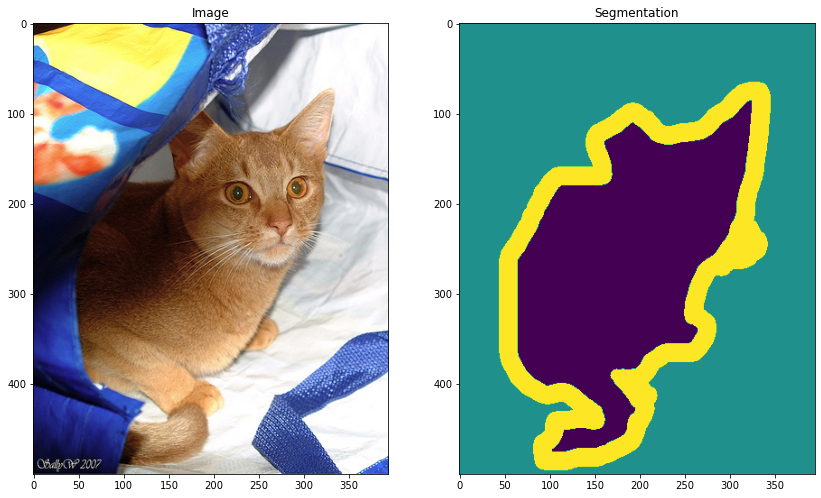

In [3]:
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask)
arr[1].set_title('Segmentation')

In [5]:
image_list_ds = tf.data.Dataset.list_files(image_list[:10], shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list[:10], shuffle=False)

# for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
#     print(path)

In [6]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'./images/original/Abyssinian_1.jpg', shape=(), dtype=string)
tf.Tensor(b'./images/masks/Abyssinian_1.png', shape=(), dtype=string)


### 10.2 - Process

In [10]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (128, 128), method='nearest')
    input_mask = tf.image.resize(mask, (128, 128), method='nearest')
#     print(input_mask)
    input_image = input_image / 255.
    input_mask = input_mask / 255
    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)
processed_image_ds

<MapDataset shapes: ((128, 128, 3), (128, 128, 1)), types: (tf.float32, tf.float32)>

### 7.3 - Add Model Dims

In [14]:
unet = UNetCompiled(input_size=(128, 128, 3), n_filters=16, n_classes=1)

In [15]:
unet.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 16)   0           conv2d_1[0][0]                   
_______________________________________________________________________________________

## 7.4 Loss Function

In [16]:
unet.compile(optimizer='adam', #tf.keras.optimizers.Adam(lr=base_learning_rate) --> run diff learning rate
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])
# capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
# train_op = optimizer.apply_gradients(capped_gvs)

## 7.5 Train Model

In [ ]:

results = model.fit(X_train, y_train, batch_size=32, epochs=100, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))


In [17]:
EPOCHS = 20
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

## ADD BATCH NORMALIZATION

(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None))
Epoch 1/20
 51/231 [=====>........................] - ETA: 24:09 - loss: 0.0463 - accuracy: 0.0000e+00

KeyboardInterrupt: 

## Create Predicted Masks

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

## Prediction Examples

True and False

In [ ]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])